## 95-851: Social Media Analysis
### Data Clan
#### Part 2: Important Attribute Analysis

### 1. Load Data

In [0]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import spacy
import seaborn as sns

In [0]:
import re
import string
import codecs

def makeWordList(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [0]:
# load text corpus
#Both_IPhones_data
df = pd.read_csv('./Cleaned/Both_iPhones_data.csv', encoding='utf-8')

### 2. iPhone Analysis

#### Sources of iPhone posts:

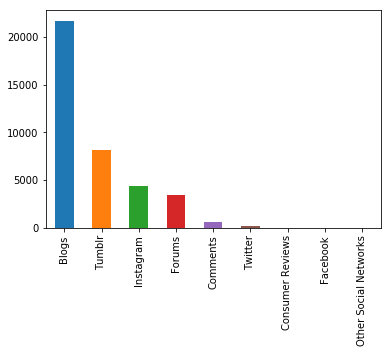

In [0]:
df['Source Type'].value_counts().plot('bar')

As we can see majority of the reviews/posts come from blogs.

In [0]:
corpus = list(df['Sound Bite Text'])

In [0]:
corpus[0]

'Following the naming system of the past several years of the iPhone, this year’s release would be named the iPhone 7s. Talk suggests there will still be the release of the iPhone 7s in the addition to the newer model. What this will be named – iPhone 8, iPhone 10, iPhone X, something completely different – we’ll just have to wait and see! Lesson of the Week: Julian Robertson “Our mandate is to find the 200 best companies in the world and invest in them, and find the 200 worst companies in the world and go short on them.'

In [0]:
len(corpus)

38405

There 38405 reviews/posts on iPhone 8 and iPhone X combined

In [0]:
import spacy 
nlp = spacy.load('en', disable=['ner', 'parser', 'tagger']) #disabling to optimize loading time

def word_tokenizer(doc):
    parsed_doc = nlp(doc)
    return([token.lemma_.lower() for token in parsed_doc if re.match('[a-zA-Z]+$', token.orth_) and token.lemma_ != '-PRON-'])

In [0]:
from sklearn.feature_extraction import text
my_stop_words = text.ENGLISH_STOP_WORDS.union(['iphone', 'apple', 'mac', 'ipad', 'plus', 'iphonex', 'applewatch', 'macbook'])

In [0]:
#constructing a document matrix
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=50, stop_words=my_stop_words, max_df=0.8, tokenizer=word_tokenizer)
doc_matrix = vectorizer.fit_transform(corpus)
print('Number of features in tf-idf:', len(vectorizer.vocabulary_)) # a mapping of terms to feature indices

Number of features in tf-idf: 3324


In [0]:
doc_matrix = doc_matrix.toarray()

In [0]:
doc_matrix.shape

(38405, 3324)

After feature engineering, we have extract 3324 feature values corresponding to 38405 posts/reviews.

In [0]:
#constructing feature set
feature_set = pd.DataFrame(doc_matrix)

In [0]:
feature_set.columns = vectorizer.get_feature_names()

In [0]:
feature_set.head()

,10,2,3,4,5,a.m.,aapl,abandon,ability,able,...,youtuber,yuan,zaharov,zdnet,zealand,zero,zhang,zone,zoom,﻿1
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.085010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044867
2,0.091318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.090216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019827


In [0]:
num_topics = 10
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=num_topics, learning_method='online', max_iter=10, n_jobs=-1 , random_state=0)
lda.fit(doc_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [0]:
print("Log Likelihood: ", lda.score(doc_matrix))

Log Likelihood:  -1577041.7641789156


In [0]:
print("Perplexity: ", lda.perplexity(doc_matrix))

Perplexity:  3110.62261221589


In [0]:
best_topics = 10
best_lda_model = lda

In [0]:
# Topic - Word matrix
topic_keywords_matrix = pd.DataFrame(best_lda_model.components_)
topic_keywords_matrix.columns = vectorizer.get_feature_names()

In [0]:
topic_word_distributions = np.array([topic_word_pseudocounts / np.sum(topic_word_pseudocounts)
                                     for topic_word_pseudocounts in best_lda_model.components_])

In [0]:
word_columns = vectorizer.get_feature_names()

#### Classify posts based on common themes

In [0]:
# Top 20 words per topic
print('Displaying the top %d words per topic and their probabilities within the topic...' % 20)
print()

for topic_idx in range(best_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(topic_word_distributions[topic_idx])[::-1]
    for rank in range(20):
        word_idx = sort_indices[rank]
        print(word_columns[word_idx], ':', topic_word_distributions[topic_idx, word_idx])
    print()



Displaying the top 20 words per topic and their probabilities within the topic...

[Topic 0]
gb : 0.08124314795349012
gold : 0.04410283249794682
silver : 0.03711345405706172
iphonex : 0.0285691050166316
grey : 0.02727555025725522
ready : 0.026801837573345554
warranty : 0.021902380389274053
idr : 0.02064325040860555
space : 0.018827639424979174
black : 0.01584397212368294
color : 0.01509612515748844
appletv : 0.013902717245887595
po : 0.013067984098703432
plus : 0.011254466475556044
instagood : 0.010192217994243068
order : 0.010189852782789836
eta : 0.0098416074187699
available : 0.009334004021601942
open : 0.009299183846883606
jualiphone : 0.008682850861908217

[Topic 1]
apple : 0.01815531268165605
new : 0.0086841931537251
plus : 0.008435350915833199
price : 0.008331457723834815
launch : 0.008097981188887608
order : 0.00793602440560132
pre : 0.0067097997776872885
buy : 0.00602034729244769
release : 0.005694689001243799
say : 0.005668815577593309
store : 0.005218897977990837
year : 0.00

Topic 0 gives us an idea that users are talking about color of the phone here. Top keywords are 'black' 'color', 'gold' color, 'silver' color, 'warranty' and 'space'.

Topic 1 tells us that here users are talking about price, cost etc.

Topic 2 tells us that here users are talking about display, design, look, pixel, screen etc.

Topic 3 tells us that users here are talking about charge/charging, plug, power, wireless

Topic 4 seems irrelevant to our analysis

Topic 5 users are talking about charging/power similar to topic 3.

Topic 6, 7, 8, 9 seems irrelevant.

#### Experimentation with bigrams (instead of unigrams as per above)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
countvectorizer = CountVectorizer(min_df=50, stop_words=my_stop_words, max_df=0.8, tokenizer=word_tokenizer, ngram_range=(2,2))
count_matrix = countvectorizer.fit_transform(corpus)
print('Number of features in tf-idf:', len(countvectorizer.vocabulary_)) # a mapping of terms to feature indices

Number of features in tf-idf: 4668


In [0]:
count_matrix = count_matrix.toarray()
sum_bigrams = count_matrix.sum(axis=0) 
words_freq = [(word, sum_bigrams[idx]) for word, idx in countvectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [0]:
words_freq[:30]

[('wireless charge', 10643),
 ('pre order', 6228),
 ('new x', 3829),
 ('watch series', 3683),
 ('new iphones', 3570),
 ('gb gb', 3536),
 ('home button', 2675),
 ('augment reality', 2482),
 ('new phone', 2421),
 ('new feature', 2406),
 ('fast charge', 2285),
 ('flag irrelevant', 2185),
 ('portrait light', 1944),
 ('edge edge', 1775),
 ('appear \ufeff1', 1742),
 ('bionic chip', 1730),
 ('portrait mode', 1699),
 ('facial recognition', 1689),
 ('battery life', 1681),
 ('charge pad', 1678),
 ('steve job', 1613),
 ('new model', 1507),
 ('dual camera', 1455),
 ('x come', 1422),
 ('wireless charger', 1371),
 ('usb c', 1365),
 ('x x', 1335),
 ('tim cook', 1290),
 ('oled display', 1278),
 ('brand new', 1278)]

### Most important attributes for iPhone:
The 30 most frequently occuring bigrams in the reviews/post based on the above analysis.
This gives us a hint on what features/characteristics of the phone are being discussed by the users the most.
Some of the most talked about attributes based on our analysis above were:
1. Wireless charging
2. Home button (Apple removed home button from iPhone X, so this generated a good amount of discussion among users)
3. Fast Charge
4. Portrait lighting (New feature introduced in iPhone)
5. Bionic Chip (Apple introduced this new feature iPhone 8 onwards)
6. Facial recognition (Apple introduced this new feature iPhone 8 onwards)
7. Charge Pad (Apple introduced this new feature iPhone 8 onwards)
8. Dual Camera
9. Oled Display (New OLED screen for iPhone X)

#### Perform bigram topic modeling

In [0]:
#constructing a document matrix
vectorizer2 = TfidfVectorizer(min_df=50, stop_words=my_stop_words, max_df=0.8, tokenizer=word_tokenizer, ngram_range=(2,2))
doc_matrix2 = vectorizer2.fit_transform(corpus)
print('Number of features in tf-idf:', len(vectorizer2.vocabulary_)) # a mapping of terms to feature indices

Number of features in tf-idf: 4668


In [0]:
doc_matrix2 = doc_matrix2.toarray()

In [0]:
doc_matrix2.shape

(38405, 4668)

After feature engineering, we have extract 3324 feature values corresponding to 38405 posts/reviews.

In [0]:
#constructing feature set
feature_set2 = pd.DataFrame(doc_matrix2)

In [0]:
feature_set2.columns = vectorizer2.get_feature_names()

In [0]:
feature_set2.head()

,10 anniversary,2 generation,2 new,3 generation,3 party,3 quarter,4 quarter,aapl stock,able charge,able make,...,﻿1 reveal,﻿1 review,﻿1 smartphone,﻿1 smartphones,﻿1 spot,﻿1 thing,﻿1 time,﻿1 version,﻿1 wave,﻿1 x
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.133166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.136158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.136158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
num_topics = 10
from sklearn.decomposition import LatentDirichletAllocation
lda2 = LatentDirichletAllocation(n_components=num_topics, learning_method='online', max_iter=10, n_jobs=-1 , random_state=0)
lda2.fit(doc_matrix2)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [0]:
print("Log Likelihood: ", lda2.score(doc_matrix2))

Log Likelihood:  -1118189.9989448085


In [0]:
print("Perplexity: ", lda2.perplexity(doc_matrix2))

Perplexity:  8249.049629477855


In [0]:
# Select the best hyperparameters
best_topics2 = 10
best_lda_model2 = lda2

In [0]:
# Topic - Word matrix
topic_keywords_matrix2 = pd.DataFrame(best_lda_model2.components_)
topic_keywords_matrix2.columns = vectorizer2.get_feature_names()

In [0]:
topic_word_distributions2 = np.array([topic_word_pseudocounts / np.sum(topic_word_pseudocounts)
                                     for topic_word_pseudocounts in best_lda_model2.components_])

In [0]:
word_columns2 = vectorizer2.get_feature_names()

In [0]:
# Top 20 words per topic
print('Displaying the top %d bigrams per topic and their probabilities within the topic...' % 20)
print()

for topic_idx in range(best_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices2 = np.argsort(topic_word_distributions2[topic_idx])[::-1]
    for rank in range(20):
        word_idx = sort_indices2[rank]
        print(word_columns2[word_idx], ':', topic_word_distributions2[topic_idx, word_idx])
    print()



Displaying the top 20 bigrams per topic and their probabilities within the topic...

[Topic 0]
wireless charge : 0.01777715387585753
fast charge : 0.005707561620969423
home button : 0.005619200957530918
new x : 0.005398372501192109
new iphones : 0.00480258993425143
new feature : 0.004261652655317761
watch series : 0.004260063519744209
battery life : 0.004204906541827839
charge pad : 0.004000343630079443
bionic chip : 0.0037819184737335715
oled display : 0.0037052513743764666
facial recognition : 0.0033390255074162135
edge edge : 0.003289685871626061
dual camera : 0.003283278056528878
usb c : 0.003269607419867699
qi wireless : 0.0031986219364717925
new phone : 0.0031846874940162266
x screen : 0.0031141966471887146
x new : 0.0030215366906442506
augment reality : 0.002967439346028165

[Topic 1]
gb gb : 0.03762385944149371
t mobile : 0.01874271496916777
space grey : 0.01840246092550391
click expand : 0.01592886398264929
reason buy : 0.015287086148785026
press release : 0.012144052130992962

### 2. Galaxy S8 Analysis

In [0]:
# load text corpus
# samsung_data
df = pd.read_csv('./Cleaned/samsung_data.csv', encoding='utf-8')

#### Sources of Galaxy S8 posts:

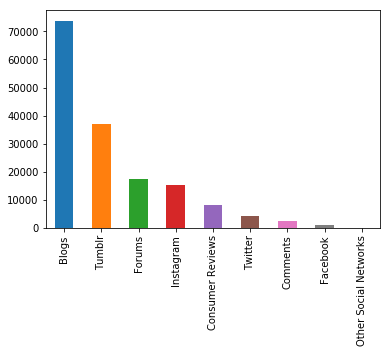

In [0]:
df['Source Type'].value_counts().plot('bar')

As we can see majority of the reviews/posts come from blogs.

In [0]:
corpus = list(df['Sound Bite Text'])

In [0]:
corpus[0]

'Samsung Galaxy S8 G950U G950P Sprint unlock by usb cable On Cell Phone Forums Need to unlock a S8 Sprint ? Find here an exclusive Sprint Samsung Galaxy S8 G950U G950P unlock method, available for this phone model that cannot be unlocked by unlock codes. This Samsung Galaxy S8 unlock service is the only option to unlock this phone model and make it work both in the USA and abroad on any gsm network. The SM-G950U G950P unlock is done online by USB cable, not by codes calculated from IMEI. ... Supported models - Sprint Samsung Galaxy S8 G950U G950P HOW THE SAMSUNG GALAXY S8 UNLOCK IS DONE? Important: We are available according to our Online program , there is shown if are available at a certain time. After buying this Sprint Samsung s8 unlock service, you will receive in a few minutes the instructions about how to prepare your computer and phone before the online unlock (some simple steps in our video tutorial, takes less than 5 min).'

In [0]:
len(corpus)

159419

There 159419 reviews/posts on Samsung

In [0]:
import spacy 
nlp = spacy.load('en', disable=['ner', 'parser', 'tagger']) #disabling to optimize loading time

def word_tokenizer(doc):
    parsed_doc = nlp(doc)
    return([token.lemma_.lower() for token in parsed_doc if re.match('[a-zA-Z]+$', token.orth_) and token.lemma_ != '-PRON-'])

In [0]:
from sklearn.feature_extraction import text
my_stop_words = text.ENGLISH_STOP_WORDS.union(['android', 'samsung', 'galaxy'])

In [0]:
#constructing a document matrix
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=50, stop_words=my_stop_words, max_df=0.8, tokenizer=word_tokenizer, max_features=10000)
doc_matrix = vectorizer.fit_transform(corpus)
print('Number of features in tf-idf:', len(vectorizer.vocabulary_)) # a mapping of terms to feature indices

Number of features in tf-idf: 5893


In [0]:
doc_matrix = doc_matrix.toarray()

In [0]:
doc_matrix.shape

(159419, 5893)

After feature engineering, we have extract 3324 feature values corresponding to 38405 posts/reviews.

In [0]:
#constructing feature set
feature_set = pd.DataFrame(doc_matrix)

In [0]:
feature_set.columns = vectorizer.get_feature_names()

In [0]:
feature_set.head()

,2,3,4,5,8,a.m.,abandon,abhijeet,ability,able,...,zenfone,zenpad,zero,zip,zipper,zone,zoom,zooper,zte,﻿1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.324986
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [0]:
num_topics = 10
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=num_topics, learning_method='online', max_iter=10, n_jobs=-1 , random_state=0)
lda.fit(doc_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [0]:
print("Log Likelihood: ", lda.score(doc_matrix))

Log Likelihood:  -5798516.057844428


In [0]:
print("Perplexity: ", lda.perplexity(doc_matrix))

Perplexity:  4538.315328002736


In [0]:
# Select the best hyperparameters
best_topics = 10
best_lda_model = lda

In [0]:
# Topic - Word matrix
topic_keywords_matrix = pd.DataFrame(best_lda_model.components_)
topic_keywords_matrix.columns = vectorizer.get_feature_names()

In [0]:
topic_word_distributions = np.array([topic_word_pseudocounts / np.sum(topic_word_pseudocounts)
                                     for topic_word_pseudocounts in best_lda_model.components_])

In [0]:
word_columns = vectorizer.get_feature_names()

#### Classify posts based on common themes

In [0]:
# Top 20 words per topic
print('Displaying the top %d words per topic and their probabilities within the topic...' % 20)
print()

for topic_idx in range(best_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(topic_word_distributions[topic_idx])[::-1]
    for rank in range(20):
        word_idx = sort_indices[rank]
        print(word_columns[word_idx], ':', topic_word_distributions[topic_idx, word_idx])
    print()

Displaying the top 20 words per topic and their probabilities within the topic...

[Topic 0]
order : 0.025629200779942435
pre : 0.023921682668846124
red : 0.0200222946339203
update : 0.019982828284417258
tint : 0.017059332137557472
mobile : 0.016332604114190775
fix : 0.014775292640924982
issue : 0.014586623602296258
t : 0.014016315097136106
april : 0.012957829245554362
unlock : 0.011438362430679635
carrier : 0.011053283721860265
available : 0.010391017561181994
verizon : 0.00990162520947982
preorder : 0.009302892980303549
start : 0.009047962760063819
plus : 0.008824077481106484
free : 0.007711189121191785
buy : 0.007628000092502139
customer : 0.007606230136410973

[Topic 1]
dex : 0.05082160971296733
desktop : 0.030507896922510797
dock : 0.028539222046489263
cnet : 0.026972042363368698
send : 0.024042807306729905
icon : 0.023636572949141302
launcher : 0.022831299760820677
use : 0.022076469307822748
station : 0.02028452643008502
gagt : 0.01979355103667749
pc : 0.012929465571382692
theme 

#### Experimentation with bigrams (instead of unigrams as per above)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
countvectorizer = CountVectorizer(min_df=50, stop_words=my_stop_words, max_df=0.8, tokenizer=word_tokenizer, ngram_range=(2,2), max_features=10000)
count_matrix = countvectorizer.fit_transform(corpus)
print('Number of features in tf-idf:', len(countvectorizer.vocabulary_)) # a mapping of terms to feature indices

Number of features in tf-idf: 10000


In [0]:
count_matrix = count_matrix.toarray()
sum_bigrams = count_matrix.sum(axis=0) 
words_freq = [(word, sum_bigrams[idx]) for word, idx in countvectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [0]:
words_freq[:30]

[('pre order', 13278),
 ('gb ram', 8942),
 ('t mobile', 8295),
 ('appear \ufeff1', 7467),
 ('infinity display', 6357),
 ('new phone', 5603),
 ('new flagship', 5374),
 ('gear vr', 5336),
 ('screen protector', 4944),
 ('google pixel', 4895),
 ('home button', 4839),
 ('tag ifttt', 4769),
 ('iris scanner', 4667),
 ('pixel xl', 4478),
 ('bixby button', 4340),
 ('look like', 4275),
 ('fingerprint sensor', 4090),
 ('south korea', 3956),
 ('bixby voice', 3814),
 ('ram gb', 3799),
 ('flag irrelevant', 3799),
 ('new york', 3777),
 ('flagship phone', 3642),
 ('facial recognition', 3582),
 ('midnight black', 3522),
 ('aspect ratio', 3505),
 ('battery life', 3405),
 ('wireless charge', 3336),
 ('red tint', 3260),
 ('fingerprint scanner', 3254)]

### Most important attributes for Galaxy S8:
The 30 most frequently occuring bigrams in the reviews/post based on the above analysis.
This gives us a hint on what features/characteristics of the phone are being discussed by the users the most.
Some of the most talked about attributes based on our analysis above were:
1. Memory (as indicated by 'gb ram')
2. Infinity display
3. Iris Scanner
4. Bixby button
5. Fingerprint sensor/scanner
6. Bixby voice
7. Facial recognition
8. Red tint (an issue faced by some users with Samsung products) 
9. Battery life
10. Wireless charger